# Object-Based Augmentation

This notebook provides insights into the workflow of Object-Based Augmentation.

In [ ]:
import os
import sys
sys.path.append(os.path.abspath(".."))
from utils.loading import load_masked_images, load_images, load_labels
from utils.visualization import plot_image, plot_masked_image
from utils.normalize import normalize
import random

print(os.getcwd())

/Users/synneandreassen/Documents/MasterMaskinlæring/INF367A/Competition/INF367A-Solafune/OBA


In [2]:
example_img = '/data/train_images/train_0.tif'
example_img = example_img.replace('/notebooks', '')
#example_img = example_img.replace('INF367A-Solafune/', '')
print("Updated path:", example_img)

plot_image(example_img, band=2)

Updated path: /data/train_images/train_0.tif
No annotations found for /data/train_images/train_0.tif


## Initiate OBA Generator

In [4]:
from OBA.object_based_augmentation import Generator

generator = Generator(batch_size=10, subset=True)

Loaded 30 masked images.
Loaded 30 images.
Found 30 file names
Loaded 30 labels.
Extracted 191 objects from 12 files.


## Augmentation 

In [18]:
from OBA.augmentation import augment

example_img = 'train_0.tif'
image = generator.images[example_img]["image"]
mask = generator.masks[example_img]["image"]
print("Image shape:", image.shape)
print("Mask shape:", mask.shape)
print("No augmentation")
augmented_image, augmented_mask = augment(image, mask, augm_prob=1, color_aug_prob=0, geometric_aug_prob=0)
generator.visualize(augmented_image, augmented_mask)
print("Color augmentation")
augmented_image, augmented_mask = augment(image, mask, augm_prob=1, color_aug_prob=1, geometric_aug_prob=0)
generator.visualize(augmented_image, augmented_mask)
print("Geometric augmentation")
augmented_image, augmented_mask = augment(image, mask, augm_prob=1, color_aug_prob=0, geometric_aug_prob=1)
generator.visualize(augmented_image, augmented_mask)

Image shape: (12, 1024, 1024)
Mask shape: (1, 1024, 1024)
No augmentation


/Users/synneandreassen/Documents/MasterMaskinlæring/INF367A/Competition/INF367A-Solafune/OBA/augmentation.py:27: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  Lambda(
/Users/synneandreassen/Documents/MasterMaskinlæring/INF367A/Competition/INF367A-Solafune/OBA/augmentation.py:31: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  Lambda(


ValueError: Height and Width of image, mask or masks should be equal. You can disable shapes check by setting a parameter is_check_shapes=False of Compose class (do it only if you are sure about your data consistency).

191
[184, 185, 188, 189, 190, 192, 195, 196, 197, 200, 123, 124, 125, 126, 127, 128, 129, 266, 267, 268, 269, 272, 273, 274, 114, 115, 116, 117, 118, 120, 121, 122, 181, 182, 183, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178, 180, 166, 147, 148, 149, 150, 151, 153, 155, 162, 163, 164, 165, 58, 3, 4, 10, 14, 21, 22, 23, 24, 26, 27, 32, 33, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 51, 56, 57, 0, 1, 2, 59, 60, 64, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 78, 85, 86, 87, 88, 89, 90, 91, 92, 134, 136, 138, 139, 140, 141, 142, 146, 225, 227, 228, 229, 230, 81, 83, 84, 104, 105, 106, 107, 108, 109, 110, 249, 250, 251, 252, 254, 255, 261, 262, 264, 265, 242, 243, 244, 245, 246, 247, 248, 111, 112, 113, 223, 224, 101, 102, 103, 231, 232, 233, 235, 236, 239, 241, 93, 94, 95, 96, 97, 98, 215, 217, 218, 219, 220, 222]
image_path:  data/train_images/train_25.tif


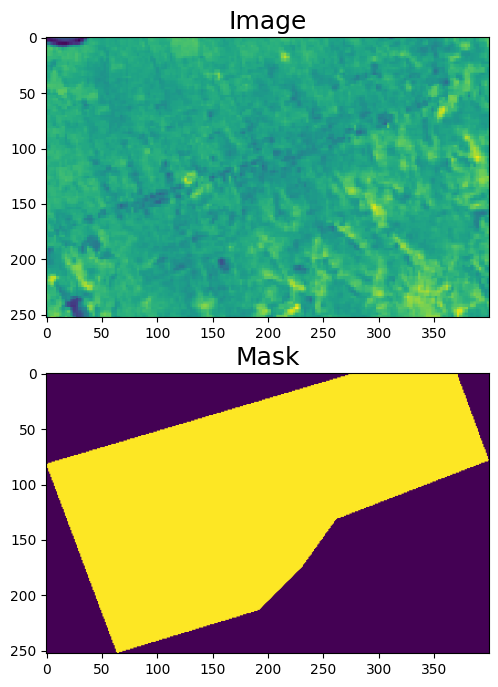

In [ ]:
print(generator.num_of_extracted_objects)
object_ids = [obj[-1] for obj in generator.extracted_objects]
print(object_ids)
num = random.choice(object_ids) # choose random object
band = 5
cropped_object, object_mask = generator._crop_target_object(num)
generator.visualize(cropped_object[band], object_mask) # image: (12, 1024, 1024), mask: (1, 1024, 1024)

/Users/synneandreassen/Documents/MasterMaskinlæring/INF367A/Competition/INF367A-Solafune
Result:


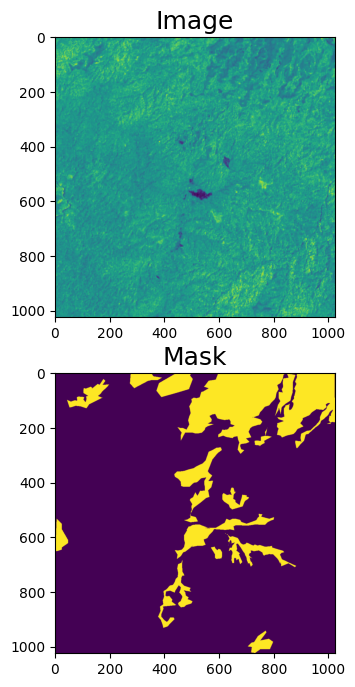

In [ ]:
generator.augm = True

generator.augm_prob = 1
generator.geometric_augm_prob = 1
generator.color_augm_prob = 0

generator.object_augm = True
generator.object_augm_prob = 1

generator.background_augm_prob = 0

generator.shadows = False

generator.extra_objects = 5

# not currently integrated
generator.extra_background_prob = 0
print(os.getcwd())
image, mask, profile = generator.generate_augmented_sample()
print("Result:")
generator.visualize(image[5], mask[0]) # image: (12, 1024, 1024), mask: (1, 1024, 1024)

In [ ]:
plot_image(image, band=1, num_plots=12, polygons=False)

NameError: name 'plot_image' is not defined

In [ ]:
from OBA.object_based_augmentation import create_OBA_tensor_dataset
dataset = create_OBA_tensor_dataset(
    prob_of_OBA=0.3, 
    subset=True,
    augm=True, 
    object_augm=True, 
    extra_background_prob=0, # not implemented
    background_augm_prob=0.6,
    shadows=False, # not usefull
    extra_objects=3,
    object_augm_prob=1,
    augm_prob=1,
    geometric_augm_prob=1,
    color_augm_prob=1,
    batch_size=1,
    min_area=100,
    use_SR=False
)

Loaded 30 images.
Loaded 30 masked images.
Found 30 file names


AttributeError: 'Generator' object has no attribute 'images'

In [ ]:
folder = './data/oba_images/'
masked = './data/oba_masked_images/'
oba_images = [f for f in os.listdir(folder) if f.startswith('OBA')]
oba_masks = [f for f in os.listdir(masked) if f.startswith('OBA')]
print(f"Number of files starting with 'OBA': {len(oba_images)} in folder {folder}")
print(f"Number of files starting with 'OBA': {len(oba_masks)} in folder {masked}")

Number of files starting with 'OBA': 93 in folder ./data/oba_images/
Number of files starting with 'OBA': 93 in folder ./data/oba_masked_images/


The number of images and masks generated during creation of the dataset vary depending on the probability of OBA. This is a parameter easy to vary.